

## Feature Engineering


We will add some more features.

In [1]:
import warnings
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.special import inv_boxcox, boxcox1p
from pprint import pprint

# supress unnecessary warnings for readability and cleaner presentation
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('bmh')

In [2]:
# helper function which performs all steps of data processing which we applied during 
# Data cleaning and preprocessing
def read_clean_data():
    
    # reading data
    df_train = pd.read_csv('use_case_data.csv')
    df_score = pd.read_csv('score_data.csv')

    df_train['data_type'] = 'train'
    df_score['data_type'] = 'score'
    
    # removing negative market shares
    temp = df_train[df_train['Market_Share'] >= 0]
    
    # applying boxcox
    market_share = stats.boxcox(temp['Market_Share'].values + 1e-30, lmbda=0.25)
    
    # combining train and score
    data = pd.concat([temp.drop(columns='Market_Share'), df_score],ignore_index=True)
    
    # adding response variable
    data['Market_Share'] = np.nan
    mask = data['data_type'] == 'train'
    data.loc[mask, 'Market_Share'] = market_share
    data.drop(columns='data_type', inplace=True)
    
    # changing dtype to category
    data['ITEMSCODE'] = data['ITEMSCODE'].astype('category')

    # spliting to year and month, adding to not_useful_features list
    data['LAUNCH_YEAR'], data['LAUNCH_MONTH'] = data['NPLLAUNCHDATE'].map(str).apply(lambda x: [x[:4], x[4:]]).str   
    
    # removing not useful features
    not_useful = ['BRMID', 'LATESTPERIODINDEX', 'NPLLAUNCHDATE', 'ISREPLACEMENT', 'BRM', 'MARKETEDBRAND',
                  'BRANDSUBFAMILY', 'NPLLAUNCHYEAR', 'RTYPE', 'ITEMSHAPE']    
    data.drop(columns=not_useful, inplace=True)
    
    # filling missing values
    data['SPECIALFLAVOR'].fillna('NOSPECIALFLAVOR', inplace=True)
    data['TIPCOLOR'].fillna('NOTIPCOLOR', inplace=True)
    
    # transform categorical features into the appropriate type
    for c in data.columns:
        col_type = data[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            data[c] = data[c].astype('category')
            
    # transforming with boxcox1p for reducing skew
    data[['LEN', 'NCON', 'RETAILPACKPRICE']] = boxcox1p(data[['LEN', 'NCON', 'RETAILPACKPRICE']], -0.25)

    print('all data shape: {}'.format(data.shape))
    return data

We will add some more features by aggregating some categorical features by numeric ones.

For example, we will calculate **mean, median, std, skew** of **RETAILPACKPRICE** for each **REGION**. 

In [3]:
def aggregate(data, f_1, f_2):
    """Aggregates f_1 by f_2"""

    mean_ = '{}_{}_mean'.format(f_1, f_2)
    median_ = '{}_{}_median'.format(f_1, f_2)
    std_ = '{}_{}_std'.format(f_1, f_2)
    skew_ = '{}_{}_skew'.format(f_1, f_2)
    
    # aggregation of f_1 by f_2
    temp = data.groupby(f_1)[f_2].aggregate({
        mean_: np.mean,
        std_: np.std,
        median_: np.median,
        skew_: stats.skew
    }).reset_index()
    
    # filling nans with 0
    for x in (mean_, std_, median_, skew_):
        temp[x].fillna(0, inplace=True)
        
    data = data.merge(temp)
    
    # adding relative (for example product RETAILPACKPRICE / REGION mean RETAILPACKPRICE)
    relative_mean_ = '{}_{}_relative_mean'.format(f_1, f_2)
    relative_median_ = '{}_{}_relative_median'.format(f_1, f_2)
    
    def relative(row, f):
        f_value, f_2_value = row[f], row[f_2]
        if f_value == 0 and f_2_value == 0:
            return 1.
        elif f_value == 0 and f_2_value != 0:
            return -99999
        else:
            return f_2_value / f_value
        
#     data[relative_mean_] = data.apply(lambda row: relative(row, mean_), axis=1)
    data[relative_median_] = data.apply(lambda row: relative(row, median_), axis=1)
    return data

In [4]:
def feature_engineering(data, to_drop=None, to_aggregate=None, to_dummy=False, cardinality_ratio=1., ):
    """
    Recives cleaned and preprocessed data, add features, high cardinality features and makes one-hot encoding.
    """
    temp = data.copy()

    # removing high cardinality categorical features
    if cardinality_ratio < 1.:
        n = len(temp)
        high_cardinalty_features = []
        for c in temp.columns:
            if temp[c].dtype.name == 'category' and len(temp[c].unique()) / n > cardinality_ratio:
                high_cardinalty_features.append(c)
        print('Removing {} features, which have high cardinality.'.format(high_cardinalty_features))
        temp.drop(columns=high_cardinalty_features, inplace=True)
    
    # aggergation
    numeric_fs = [c for c in temp.columns if temp[c].dtype.name != 'category' and c != 'Market_Share']
    for f_1 in to_aggregate:
        for f_2 in numeric_fs:
            temp = aggregate(temp, f_1, f_2)
    
    # adding also **2, **3 and **0.5 for LEN and RETAILPACKPRICE
    for x in ['LEN', 'RETAILPACKPRICE']:
        temp['{}_**2'.format(x)] = temp[x] ** 2
        temp['{}_**3'.format(x)] = temp[x] ** 2
        temp['{}_**0.5'.format(x)] = np.sqrt(np.abs(temp[x]))        
    print('all data shape after features addition: {}'.format(temp.shape))
    
    # dropping some features
    if to_drop:
        temp.drop(columns=to_drop, inplace=True)
        print('all data shape after features deletion: {}'.format(temp.shape))
    

    # one-hot encoding for categorical features
    if to_dummy:
        temp = pd.get_dummies(temp)
        print('all data shape after one-hot-encoding: {}'.format(temp.shape))

    # splitting into train and score
    mask = temp['Market_Share'].notnull()
    training_data, score_data = temp[mask], temp[np.invert(mask)]
    score_data.drop(columns='Market_Share', inplace=True)
    print('training data shape: {}, score data shape: {}'.format(
        training_data.shape, score_data.shape))
    return training_data, score_data

**Preparing data: data clening, preprocessing and feature engineering, one-hot-encoding**

In [5]:
df = read_clean_data()

all data shape: (1721, 32)


In [6]:
# categorical features, which will be aggregated
to_aggregate = [
    'TCLASS',
    'REGION',
    'LOCALCLASS',
    'BLDIMAGE', 
    'MARKET',
    'MINDICATOR', 
    'THICATEGORY', 
    'PCKT',
]

# categorical features, which will be dropped
to_drop = [
    'BRANDSUBFAMILYGROUPING', 
    'BRANDSUBFAMILYLINE',
    'BRANDSUBFAMILYGROUP', 
    'BRANDONMARKET',
    'BRANDDIFFERENTIATOR',
]

training_df, score_df = feature_engineering(df, 
                                            to_drop=to_drop, 
                                            to_aggregate=to_aggregate,
                                            to_dummy=True, 
                                            cardinality_ratio=1.)

numeric_fs = [c for c in training_df.columns if training_df[c].dtype.name != 'category' and c != 'Market_Share']
categoircal_fs = list(set(training_df.columns) - set(numeric_fs) - {'Market_Share'})

all data shape after features addition: (1721, 198)
all data shape after features deletion: (1721, 193)
all data shape after one-hot-encoding: (1721, 517)
training data shape: (1692, 517), score data shape: (29, 516)


## Evaluation metrics

In [7]:
from sklearn.metrics import make_scorer
from sklearn.base import clone, BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from tabulate import tabulate

# importing helper functions from evaluation.py file
from evaluation import (test_model, train_model, cv_model, 
                        print_metrics, plot_model_performance,
                        plot_multiple_roc_curves)
from metrics import plot_confusion_matrix


**For comparision purposes we define a Base model: the model, which always predicts a *Failure*, because we have 81% Failures.**

In [8]:
class BaseRegressor:
    def __init__(self, threshold, **kwargs):
        self.threshold = threshold
        self.seed = np.random.RandomState(seed=33)
        self.mean = None
        self.std = None

    def predict(self, X):
        n_samples = X.shape[0]
        prediction = self.seed.normal(self.mean, self.std, n_samples)
        prediction[prediction >= self.threshold] = self.threshold * 1.1
        return prediction

    def fit(self, X, y):
        self.mean = np.mean(y[y < self.threshold])
        self.std = np.std(y[y < self.threshold])
        
    def get_params(self, deep = False):
        return {'threshold': self.threshold, 'mean':self.mean, 'std': self.std, }



## Modeling

### Data preparation

**Import librairies**

In [9]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

import lightgbm as lgb

**Train - Test split: we will keep 15% of data for final testing**

In [10]:
train, test = train_test_split(training_df, test_size=0.15, shuffle=True, random_state=67)
print(train.shape, test.shape)

(1438, 517) (254, 517)


In [11]:
# separating response variable
y_train, X_train = train['Market_Share'], train.drop(columns='Market_Share')
y_test, X_test = test['Market_Share'], test.drop(columns='Market_Share')

**Threshold for Success**

In [12]:
threshold = stats.boxcox(0.007, lmbda=0.25)

### Training & Cross Validation

**Models and their scores on 5 fold CV:**

We have selected 4 models: **Lasso, ElasticNet, ExtraTress and GradientTreeBoosting**. First 2 models are linear s are modifications of linear regession with additional constraints on regression coefficients. The last 2 models are non-linear models based on decision trees.

In [13]:
all_models, all_models_cv_scores = {}, {}

* **BASE Model**

Always predicts Failure.

In [14]:
model_name = 'Base'
model_base = BaseRegressor(threshold)

_, valid_score = cv_model(model_base, model_name, X_train, y_train, threshold)

all_models[model_name] = model_base
all_models_cv_scores[model_name] = valid_score


Base score:

╒═══════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ metric_name   │   train: mean │   train: std │   valid: mean │   valid: std │
╞═══════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ rmse          │         0.388 │        0.004 │         0.379 │        0.019 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ r_2           │        -0.547 │        0.055 │        -0.495 │        0.083 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ accuracy      │         0.809 │        0.005 │         0.809 │        0.022 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ tpr           │         0.000 │        0.000 │         0.000 │        0.000 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ fpr           │         0.000 │        0.000 │         0.000 │        0.000 │
├───────────────┼─────────

* **LASSO Regression (Sklearn):**

https://en.wikipedia.org/wiki/Lasso_(statistics)

https://scikit-learn.org/stable/modules/linear_model.html#lasso

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's **Robustscaler()** method on pipeline.

In [15]:
model_name = 'Lasso'
model_lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0003, max_iter=1e3, tol=1e-5, random_state=1))

_, valid_score = cv_model(model_lasso, model_name, X_train, y_train, threshold)

all_models[model_name] = model_lasso
all_models_cv_scores[model_name] = valid_score


Lasso score:

╒═══════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ metric_name   │   train: mean │   train: std │   valid: mean │   valid: std │
╞═══════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ rmse          │         0.208 │        0.005 │         0.272 │        0.020 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ r_2           │         0.554 │        0.006 │         0.232 │        0.048 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ accuracy      │         0.858 │        0.005 │         0.821 │        0.019 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ tpr           │         0.397 │        0.022 │         0.304 │        0.029 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ fpr           │         0.033 │        0.004 │         0.058 │        0.009 │
├───────────────┼────────

* **ElasticNet Regression (Sklearn):**

https://en.wikipedia.org/wiki/Elastic_net_regularization

https://scikit-learn.org/stable/modules/linear_model.html#elastic-net

again made robust to outliers

In [16]:
model_name = 'ElasticNet'
model_enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.8, random_state=3))
_, valid_score = cv_model(model_enet, model_name, X_train, y_train, threshold)

all_models[model_name] = model_enet
all_models_cv_scores[model_name] = valid_score


ElasticNet score:

╒═══════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ metric_name   │   train: mean │   train: std │   valid: mean │   valid: std │
╞═══════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ rmse          │         0.215 │        0.005 │         0.271 │        0.020 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ r_2           │         0.526 │        0.004 │         0.237 │        0.039 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ accuracy      │         0.853 │        0.002 │         0.819 │        0.020 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ tpr           │         0.365 │        0.021 │         0.286 │        0.025 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ fpr           │         0.031 │        0.003 │         0.055 │        0.011 │
├───────────────┼───

* **ExtraTrees Regressor (Sklearn):**

https://www.quora.com/What-is-the-extra-trees-algorithm-in-machine-learning

https://scikit-learn.org/stable/modules/ensemble.html#forest

https://stats.stackexchange.com/questions/44382/mathematics-behind-classification-and-regression-trees


In [17]:
model_name = 'ExtraTrees'
model_extratree = ExtraTreesRegressor(
    n_estimators=200,
    max_depth=50,
    min_samples_split=2, 
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0002,
    max_leaf_nodes=None,
    max_features='auto',
    min_impurity_decrease=0.00,
    random_state=32,
    n_jobs=2
)

_, valid_score = cv_model(model_extratree, model_name, X_train, y_train, threshold)

all_models[model_name] = model_extratree
all_models_cv_scores[model_name] = valid_score


ExtraTrees score:

╒═══════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ metric_name   │   train: mean │   train: std │   valid: mean │   valid: std │
╞═══════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ rmse          │         0.059 │        0.004 │         0.251 │        0.018 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ r_2           │         0.964 │        0.004 │         0.346 │        0.032 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ accuracy      │         0.977 │        0.001 │         0.839 │        0.019 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ tpr           │         0.922 │        0.010 │         0.341 │        0.085 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ fpr           │         0.010 │        0.003 │         0.044 │        0.007 │
├───────────────┼───

* **GradientTreeBoosting (LightGBM) :**

https://en.wikipedia.org/wiki/Gradient_boosting

https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d

https://lightgbm.readthedocs.io/en/latest/


In [18]:
model_name = 'GradientTreeBoosting'
model_lgb = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='rmse',
    n_estimators=5000,
    learning_rate=0.03,
    
    max_depth=6,             # Specify the max depth to which tree will grow. 
    num_leaves=24,           # Number of leaves in one tree

    min_child_weight=11,     # minimal sum hessian in one leaf
    min_data_in_leaf=20,     # Min number of data in one leaf.
    
    subsample=0.8,           # Specifies the fraction of data to be used for each iteration
    subsample_freq=1,
    bagging_seed=9,
    
    colsample_bytree=0.8,    # Specifies the fraction of features to be taken for each iteration
    feature_fraction_seed=7,
    
    min_gain_to_split=0.002, # Min gain to perform splitting
    reg_alpha=0.0,
    reg_lambda=0.0,
    n_jobs=2,
)
_, valid_score = cv_model(model_lgb, model_name, X_train, y_train, threshold)

all_models[model_name] = model_lgb
all_models_cv_scores[model_name] = valid_score


GradientTreeBoosting score:

╒═══════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ metric_name   │   train: mean │   train: std │   valid: mean │   valid: std │
╞═══════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ rmse          │         0.044 │        0.002 │         0.255 │        0.020 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ r_2           │         0.981 │        0.001 │         0.322 │        0.102 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ accuracy      │         0.976 │        0.001 │         0.830 │        0.022 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ tpr           │         0.913 │        0.002 │         0.408 │        0.064 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ fpr           │         0.009 │        0.001 │         0.070 │        0.018 │
├─────────

**Mean CV scores all models together:**

In [19]:
def print_mean_cv_scores(models_mean_cv_scores, filtered_metrics=None, include_base=True):
    models, metrics = zip(*models_mean_cv_scores.items())
    models, metrics = list(models), list(metrics)
    if not include_base:
        index = models.index('Base')
        models.pop(index)
        metrics.pop(index)

    tabular_format = defaultdict(list)
    for model_valid_score in metrics:
        for metric_name, metric_score in model_valid_score.items():
            tabular_format[metric_name].append(metric_score[0])
    
    if filtered_metrics:
        tabular_format = {k: v for k, v in tabular_format.items() if k in filtered_metrics}


    tabular_format = tabulate([[k] + v for k, v in tabular_format.items()], 
                              headers=['metric_name'] + list(models), 
                              floatfmt=",.3f",  tablefmt="fancy_grid")
    print(tabular_format)


In [20]:
print_mean_cv_scores(all_models_cv_scores)

╒═══════════════╤═════════╤═════════╤══════════════╤══════════════╤════════════════════════╕
│ metric_name   │    Base │   Lasso │   ElasticNet │   ExtraTrees │   GradientTreeBoosting │
╞═══════════════╪═════════╪═════════╪══════════════╪══════════════╪════════════════════════╡
│ rmse          │   0.379 │   0.272 │        0.271 │        0.251 │                  0.255 │
├───────────────┼─────────┼─────────┼──────────────┼──────────────┼────────────────────────┤
│ r_2           │  -0.495 │   0.232 │        0.237 │        0.346 │                  0.322 │
├───────────────┼─────────┼─────────┼──────────────┼──────────────┼────────────────────────┤
│ accuracy      │   0.809 │   0.821 │        0.819 │        0.839 │                  0.830 │
├───────────────┼─────────┼─────────┼──────────────┼──────────────┼────────────────────────┤
│ tpr           │   0.000 │   0.304 │        0.286 │        0.341 │                  0.408 │
├───────────────┼─────────┼─────────┼──────────────┼──────────────┼───

In [21]:
print_mean_cv_scores(all_models_cv_scores, filtered_metrics=['auc'], include_base=False)

╒═══════════════╤═════════╤══════════════╤══════════════╤════════════════════════╕
│ metric_name   │   Lasso │   ElasticNet │   ExtraTrees │   GradientTreeBoosting │
╞═══════════════╪═════════╪══════════════╪══════════════╪════════════════════════╡
│ auc           │   0.778 │        0.776 │        0.800 │                  0.802 │
╘═══════════════╧═════════╧══════════════╧══════════════╧════════════════════════╛


Some insights from scores: 

* As expected **Lasso** and **ElasticNet** performance are almost similar and their performance is low compared to DecisionTree models, which is also expected as we investigated that our data mostly is non linear.

* If we compare **GradientTreeBoosting** and **ExtraTrees** then we can notice that their performances are comparable: mean validation RMSE is almost equal and AUC is almost equal. We see some difference for TPR (true positive ratio - When it is actually Y, how often does it predict Y?) and FPR (false positive ratio - When it is actually N, how often does it predict Y?) metrics for given 0.7% success threshold. As we can see both are bigger for GradientTreeBoosting based model **(tpr: 0.408 vs 0.341, fpr: 0.070  vs 0.044)**. So what does it mean? We can assume that GradientTreeBoosting based model learned more from data than ExtraTrees (as it is more complex model than ExtraTrees), so it can differentiate more succesful launches, but together with that the *FPR is more by 2.6pp*, which is not good from bussiness prospective. So GradientTreeBoosting based models pays *FPR increase cost (by 2.6pp)* for having *higher TPR by 6.7pp*. 
* All models have low TPR, which is a result of having imbalanced dataset (only 19% are successes in dataset).


**Training scores on full training data for each model:**

In this section using all training data we fit model on it and afterwards using the same training data make predictions. We compare that predictions with actual data. So if the model fitted properly, it should show very high performance metrics (AUC > 0.95, RMSE < 0.06).


 model: Lasso


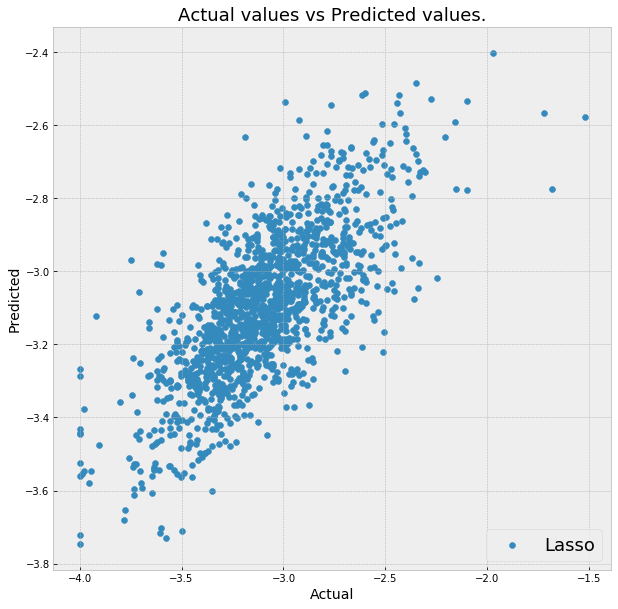

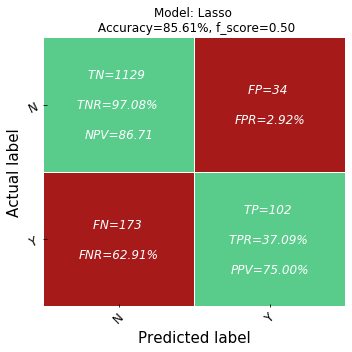




 model: ElasticNet


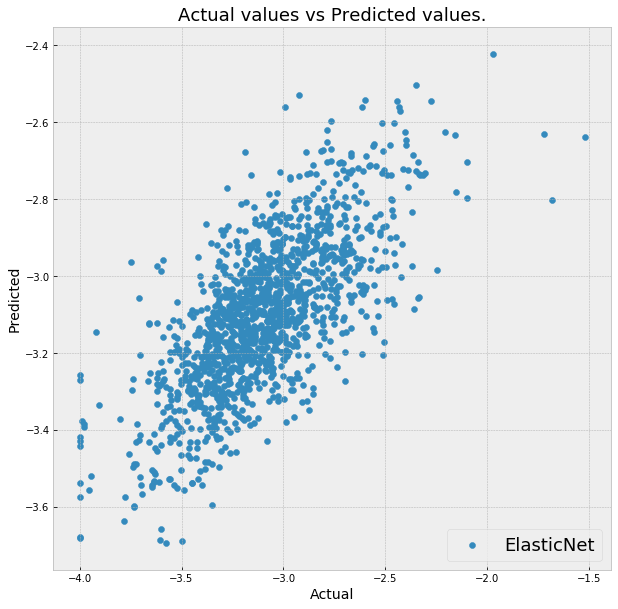

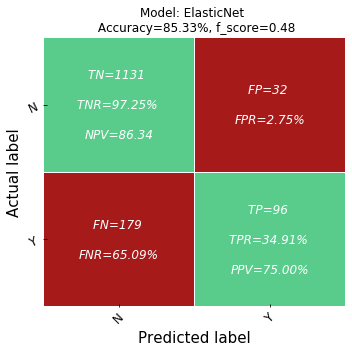




 model: ExtraTrees


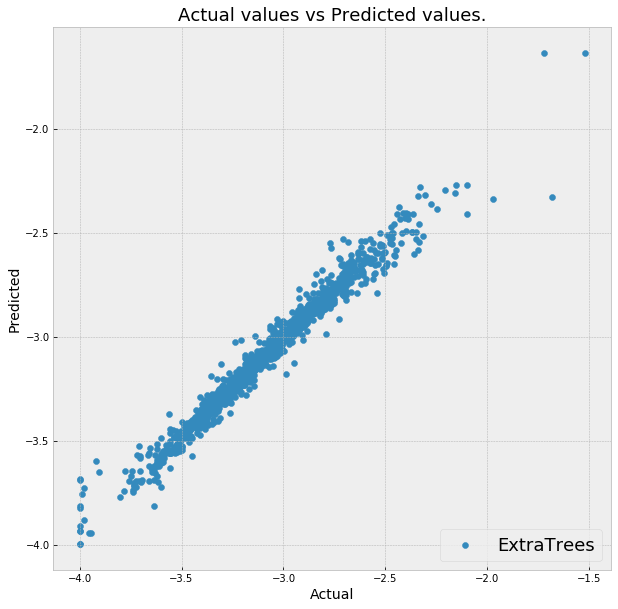

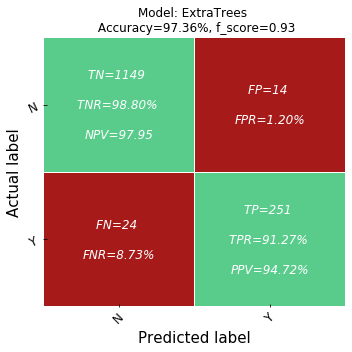




 model: GradientTreeBoosting


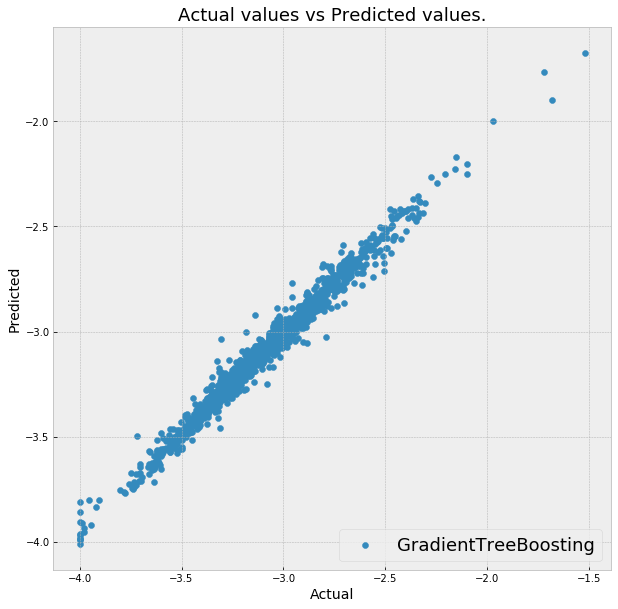

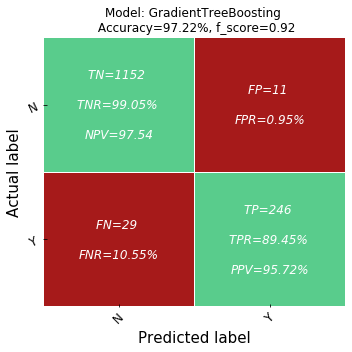

In [22]:
all_models_train_scores = {}
for name, model in all_models.items():
    if name == 'Base':
        continue
    print('\n model: {}'.format(name))
    fitted_model, y_pred, metrics = train_model(model, name, X_train, y_train, threshold, 
                                                plot=True, verbose=False)
    
    all_models[name] = fitted_model
    all_models_train_scores[name] = metrics
    print()

Lets plot all models ROC curves together.

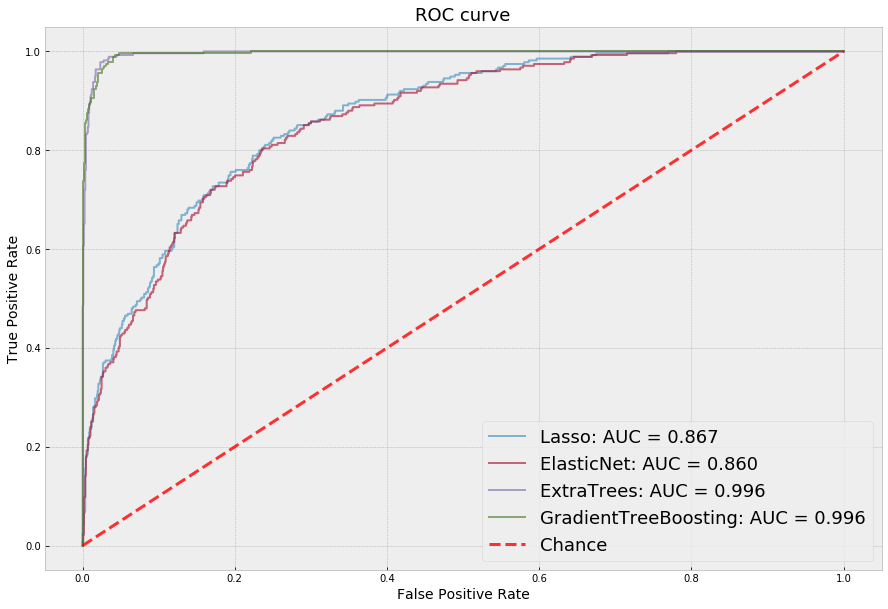

In [23]:
plot_multiple_roc_curves(all_models_train_scores)

As we can see *"linear"* models **Lasso** and **ElasticNet** are not able to fully fit even on training data. So afterwards we will not consider using them. 

In contrast,  *"non linear"* models fitted with training data almost ideally, even more they have been **overfitted**, that is why our validation scores are not high enough. It is also expected as our data is not big enough.

### Parameter optimization with GridSearch

In [24]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# importing helper functions from evaluation.py file
from evaluation import calculate_metrics

Now lets try to make some parameter optimization. We hope that this will help to overcome overfitting (at least partially).

In [25]:
# we will use AUC as an optimization metric, instead of RMSE
auc_scorer = make_scorer(lambda x, y: calculate_metrics(x, y, threshold)['auc'], greater_is_better=True)

In [26]:
all_final_models = {}

#### **ExtraTrees**

In [ ]:
params_search = {
    'n_estimators': [300, 400],
    'max_features': ['auto', 0.8, 0.7],
    'max_depth': [50, 60],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
}

gsearch = GridSearchCV(
    estimator=ExtraTreesRegressor(
    n_estimators=200,
    max_depth=50,
    min_samples_split=2, 
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0002,
    max_leaf_nodes=None,
    max_features='auto',
    min_impurity_decrease=0.00,
    random_state=32,
    n_jobs=2),
    param_grid=params_search,
    scoring=auc_scorer,
    n_jobs=4,
    iid=False,
    cv=5)

gsearch.fit(X_train, y_train)

pprint(gsearch.best_params_, )
print('best_auc: {:.4f}'.format(gsearch.best_score_))

bootstrap = gsearch.best_params_['bootstrap']
max_depth = gsearch.best_params_['max_depth']
max_features = gsearch.best_params_['max_features']
min_samples_leaf = gsearch.best_params_['min_samples_leaf']
min_samples_split = gsearch.best_params_['min_samples_split']
n_estimators = gsearch.best_params_['n_estimators']

Final results:


* n_estimators=400
* max_depth=60
* min_samples_split=2
* min_child_samples=1
* max_features=0.8,
* bootstrap=True

In [27]:
final_extratree_params = {
    'n_estimators': 400,
    'max_depth': 60,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 0.8,
    'bootstrap': True,
    'min_weight_fraction_leaf': 0.0002,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.00,
    'random_state': 32,
    'n_jobs': 2
}

In [28]:
model_name = 'ExtraTrees'
final_extratree = ExtraTreesRegressor(**final_extratree_params)

cv_model(final_extratree, model_name, X_train, y_train, threshold);
all_final_models[model_name] = final_extratree


ExtraTrees score:

╒═══════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ metric_name   │   train: mean │   train: std │   valid: mean │   valid: std │
╞═══════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ rmse          │         0.090 │        0.003 │         0.248 │        0.018 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ r_2           │         0.917 │        0.004 │         0.364 │        0.047 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ accuracy      │         0.945 │        0.005 │         0.828 │        0.016 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ tpr           │         0.744 │        0.024 │         0.248 │        0.049 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ fpr           │         0.008 │        0.002 │         0.035 │        0.009 │
├───────────────┼───

#### **GradientTreeBoosting**

https://sites.google.com/view/lauraepp/parameters?authuser=0

**Step 1: Fix learning rate and number of estimators for tuning tree-based parameters**

In [ ]:
params_search = {
    'n_estimators': range(700, 1000, 50),
    'learning_rate': [0.03]
}
gsearch = GridSearchCV(
    estimator=lgb.LGBMRegressor(
        learning_rate=0.03,
        
        max_depth=6,
        num_leaves=31,
        
        min_child_weight=1,
        min_child_samples=20,
        min_split_gain=0.0,
        
        subsample=0.8,
        subsample_freq=1,
        bagging_seed=9,
        colsample_bytree=0.8,
        feature_fraction_seed=7,
        n_jobs=2),
    param_grid=params_search,
    scoring=auc_scorer,
    n_jobs=4,
    iid=False,
    cv=5)

gsearch.fit(X_train, y_train)
print(gsearch.best_params_, 'best_auc: {:.4f}'.format(gsearch.best_score_))

n_estimators = gsearch.best_params_['n_estimators']
learning_rate = gsearch.best_params_['learning_rate']

**Step 2: Tune max_depth and num_leaves**

In [ ]:
params_search = {
    'max_depth': range(4, 8, 1), 
    'num_leaves': range(15, 127, 8)
}
gsearch = GridSearchCV(
    estimator=lgb.LGBMRegressor(
        
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        
        max_depth=6,
        num_leaves=31,
        
        min_child_weight=1,
        min_child_samples=20,
        
        subsample=0.8,
        subsample_freq=1,
        bagging_seed=9,
        colsample_bytree=0.8,
        feature_fraction_seed=7,
        n_jobs=2),
    param_grid=params_search,
    scoring=auc_scorer,
    n_jobs=4,
    iid=False,
    cv=5)

gsearch.fit(X_train, y_train)
print(gsearch.best_params_, 'best_auc: {:.4f}'.format(gsearch.best_score_))

max_depth = gsearch.best_params_['max_depth']
num_leaves = gsearch.best_params_['num_leaves']

**Step 3: Tune min_child_weight and min_child_samples**

In [ ]:
params_search = {
    'min_child_weight': [1e-3, 1e-2, 1e-1, 1., 10],
    'min_child_samples': range(1, 30, 3)
}
gsearch = GridSearchCV(
    estimator=lgb.LGBMRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        num_leaves=num_leaves,

        min_child_weight=1,
        min_child_samples=20,
        
        subsample=0.8,
        subsample_freq=1,
        bagging_seed=9,
        colsample_bytree=0.8,
        feature_fraction_seed=7,
        n_jobs=2),
    param_grid=params_search,
    scoring=auc_scorer,
    n_jobs=4,
    iid=False,
    cv=5)

gsearch.fit(X_train, y_train)
print(gsearch.best_params_, 'best_auc: {:.4f}'.format(gsearch.best_score_))

min_child_weight = gsearch.best_params_['min_child_weight']
min_child_samples = gsearch.best_params_['min_child_samples']

**Step 4: Tune min_split_gain**

In [ ]:
params_search = {
    'min_split_gain': [1e-3, 3e-3, 6e-3, 1e-2, 3e-2, 6e-2, 1e-1, 3e-1, 6e-1]
}

gsearch = GridSearchCV(
    estimator=lgb.LGBMRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        min_child_samples=min_child_samples,
        
        min_split_gain=0.0,

        subsample=0.8,
        subsample_freq=1,
        bagging_seed=9,
        colsample_bytree=0.8,
        feature_fraction_seed=7,
        n_jobs=2),
    param_grid=params_search,
    scoring=auc_scorer,
    n_jobs=4,
    iid=False,
    cv=5)

gsearch.fit(X_train, y_train)
print(gsearch.best_params_, 'best_auc: {:.4f}'.format(gsearch.best_score_))

min_split_gain = gsearch.best_params_['min_split_gain']

Final results:

* learning_rate=0.03
* n_estimators=950
* max_depth=7
* num_leaves=31
* min_child_samples=1
* min_child_weight=0.001
* min_split_gain=0.001

In [29]:
final_lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'rmse',
    'learning_rate': 0.03,
    'n_estimators': 950,
    'max_depth': 7,
    'num_leaves': 31,
    'min_child_weight': 0.001,
    'min_child_samples': 1,
    'min_split_gain': 0.001,
    'subsample': 0.8,
    'subsample_freq': 1,
    'bagging_seed': 9,
    'colsample_bytree': 0.8,
    'feature_fraction_seed': 7,
    'n_jobs': 2
}


In [30]:
model_name = 'GradientTreeBoosting'
final_lgb = lgb.LGBMRegressor(**final_lgb_params)

cv_model(final_lgb, model_name, X_train, y_train, threshold);
all_final_models[model_name] = final_lgb


GradientTreeBoosting score:

╒═══════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ metric_name   │   train: mean │   train: std │   valid: mean │   valid: std │
╞═══════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ rmse          │         0.034 │        0.001 │         0.251 │        0.017 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ r_2           │         0.988 │        0.001 │         0.345 │        0.077 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ accuracy      │         0.981 │        0.002 │         0.837 │        0.022 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ tpr           │         0.919 │        0.010 │         0.387 │        0.061 │
├───────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ fpr           │         0.005 │        0.001 │         0.057 │        0.016 │
├─────────

### Testing

Finally lets test our models.

In [31]:
import os

plots_dir = 'plots'
os.makedirs(plots_dir, exist_ok=True)

In [32]:
# first we have to fit using all train data
for model in all_final_models.values():
    model.fit(X_train, y_train)

In [33]:
# testing
all_models_test_scores = {}
for model_name, model in all_final_models.items():
    _, _,m_metrics = test_model(model, model_name, X_test, y_test, threshold, plot=False, verbose=False)
    all_models_test_scores[model_name]= m_metrics

Now lets see how **confident we are that the true success probability will fall within the range of the interval**.
This will be 95% confidence interval of PPV - positive predictive value, which shows the porbability of having positive sample (aka success), when our model predicts that sample is positive. We will use normal approximation.

**PPV ~ P(true success | model predicts success)**

In [34]:
# results
print_metrics(all_models_test_scores)
for model, metrics in all_models_test_scores.items():
    print('\n{}: PPV 95% CI=[{:.2f}, {:.2f}]'.format(model, *metrics['PPV 95% CI']))

╒═══════════════╤══════════════╤════════════════════════╕
│ metric_name   │   ExtraTrees │   GradientTreeBoosting │
╞═══════════════╪══════════════╪════════════════════════╡
│ rmse          │        0.240 │                  0.234 │
├───────────────┼──────────────┼────────────────────────┤
│ r_2           │        0.445 │                  0.470 │
├───────────────┼──────────────┼────────────────────────┤
│ accuracy      │        0.831 │                  0.846 │
├───────────────┼──────────────┼────────────────────────┤
│ tpr           │        0.240 │                  0.440 │
├───────────────┼──────────────┼────────────────────────┤
│ fpr           │        0.025 │                  0.054 │
├───────────────┼──────────────┼────────────────────────┤
│ ppv           │        0.706 │                  0.667 │
├───────────────┼──────────────┼────────────────────────┤
│ npv           │        0.840 │                  0.873 │
├───────────────┼──────────────┼────────────────────────┤
│ f_score     

**Summary:**

* **GradientTreeBoosting** is more powerful model than **ExtraTrees** in terms of **tpr (0.440 vs 0.240): probability of predicting success, when it is true success**. 

* **ExtraTrees** is more powerful model than **GradientTreeBoosting** in terms of **fpr (0.025 vs 0.054): probability of predicting success, when it is true failure**.

* As a result of having small **fpr**, **ExtraTrees** has more **positive predictive power (0.706 vs 0.667): probability of being true success, when model predicted success** than **GradientTreeBoosting**. 

* When **ExtraTrees** says success, then with 0.706 probability and [0.49, 0.92] 95% confidence interval it will be true success.
* When **GradientTreeBoosting** says success, then with 0.667 probability and [0.51, 0.83] 95% confidence interval it will be true success.

* **ExtraTrees** says success approximately 2 times rarely than **GradientTreeBoosting** in case of true success.

***So which model to select?*** 

*ExtraTrees* is conservative: almost does not predict wrong successes, but it classifies a lot of successes as failures.

On the other hand *GradientTreeBoosting* is risky: in some cases it wrongly classifies failure as a success, but it 2 times more correctly classifies successes.

The model selection should be calibrated with business needs. 

If business do not wants to lose money, with possible failures, then we should select **ExtraTrees**, as it in 97.55% percentage of actual failures, predicts failure, but it predicts successs only in 24.0% cases, when it is actual success.

If business wants to make a bit more risky investments, then we should select **GradientTreeBoosting** (94.6% vs 97.55%, 44.0% vs 24.0%).


As an algorithm  **GradientTreeBoosting** is more powerful as it has more **fpr** in case of our imbalanced data (only 19% of whole data is success). So we can say that it learned more from data than **ExtraTrees**. It has quite  higher f_score (0.530 vs  0.358), which is harmonic mean of ppv and tpr. This means that as a classificator it does it job much better.

Lets test also these models average model.

In [35]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
          # we define clones of the original models to fit the data in
        self.models = [clone(x) for x in models]
        
  
    def fit(self, X, y):
        # Train cloned base models
        for model in self.models:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models])
        return np.mean(predictions, axis=1)   


In [36]:
average_model = AveragingModels([
    ExtraTreesRegressor(**final_extratree_params),
    lgb.LGBMRegressor(**final_lgb_params)
])

average_model.fit(X_train, y_train)
all_final_models['AverageModel'] = average_model

_, _,m_metrics = test_model(average_model, 'AverageModel', X_test, y_test, threshold, plot=False, verbose=False)
all_models_test_scores['AverageModel']= m_metrics

In [37]:
# results
print_metrics(all_models_test_scores)
for model, metrics in all_models_test_scores.items():
    print('\n{}: PPV 95% CI=[{:.2f}, {:.2f}]'.format(model, *metrics['PPV 95% CI']))

╒═══════════════╤══════════════╤════════════════════════╤════════════════╕
│ metric_name   │   ExtraTrees │   GradientTreeBoosting │   AverageModel │
╞═══════════════╪══════════════╪════════════════════════╪════════════════╡
│ rmse          │        0.240 │                  0.234 │          0.233 │
├───────────────┼──────────────┼────────────────────────┼────────────────┤
│ r_2           │        0.445 │                  0.470 │          0.475 │
├───────────────┼──────────────┼────────────────────────┼────────────────┤
│ accuracy      │        0.831 │                  0.846 │          0.858 │
├───────────────┼──────────────┼────────────────────────┼────────────────┤
│ tpr           │        0.240 │                  0.440 │          0.400 │
├───────────────┼──────────────┼────────────────────────┼────────────────┤
│ fpr           │        0.025 │                  0.054 │          0.029 │
├───────────────┼──────────────┼────────────────────────┼────────────────┤
│ ppv           │        

As we see the results are interesting. The Average model has **fpr=0.029 and ppv=0.769 and tpr=0.400**. So in case of actual failure it performs like **ExtraTrees** (almost the same fpr), but in case of actual successes its performance much better and close to **GradientTreeBoosting**. Even more its **positive predictive value** is more than for each single model, which is very very good (0.769 vs 0.706 and 0.667). It has also higher auc.

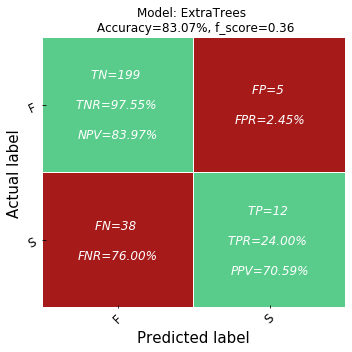

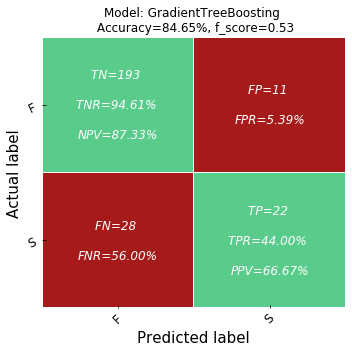

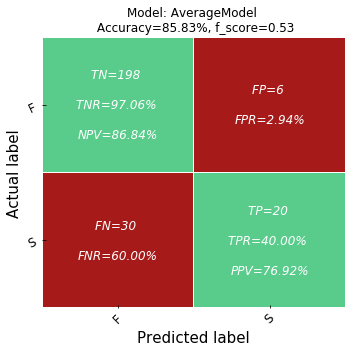

In [44]:
for model_name, model_metrics in all_models_test_scores.items():
    plot_confusion_matrix(model_metrics, label=model_name, class_labels=('F', 'S'),
                          image_path=os.path.join(plots_dir, '{}_test_cm'.format(model_name)))


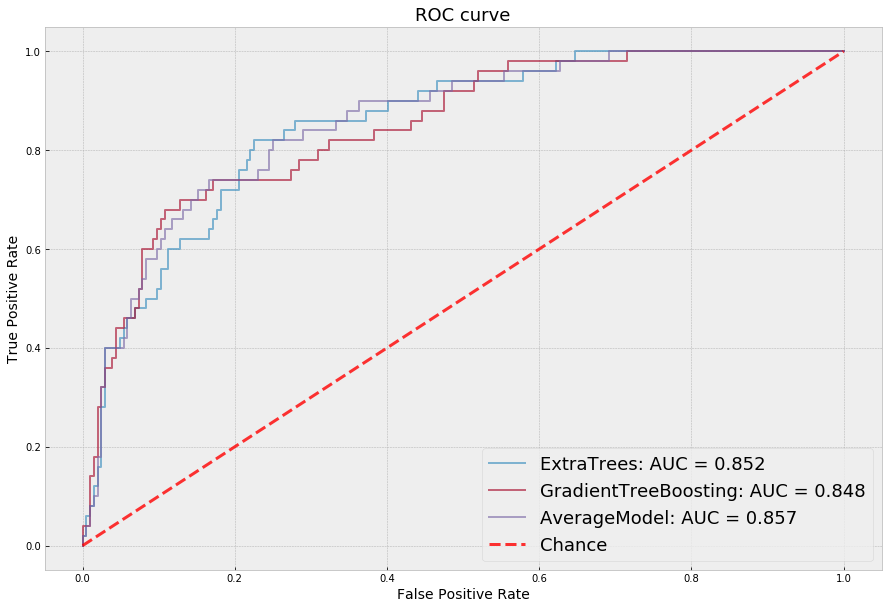

In [38]:
plot_multiple_roc_curves(all_models_test_scores, image_path=os.path.join(plots_dir, 'test_ROC_curve'))

As we can see from business perspective average model is better than each single model: it has more positive predicive value than **ExtraTrees** and less risky than **GradientTreeBoosting**. So as final model we will take AverageModel for making predictions of our score data.

Now lets find also optimal threshold for our model based on ROC curve.

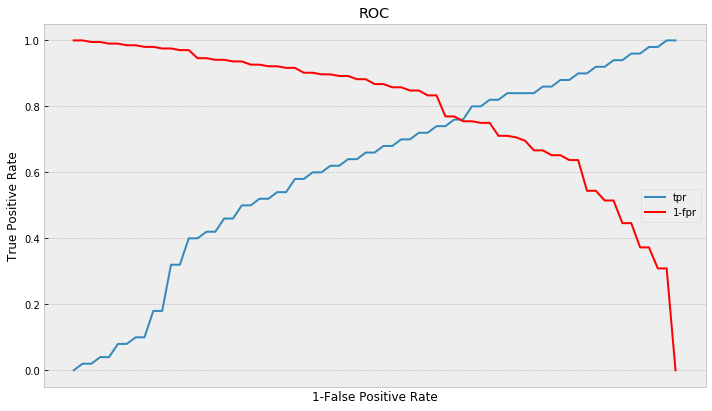

In [39]:
from sklearn.metrics import roc_curve

average_pred = average_model.predict(X_test)
binary_target = y_test > threshold
fpr, tpr, thresholds = roc_curve(binary_target, average_pred)

# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
i = np.arange(len(tpr))  # index for df
roc = pd.DataFrame({'fpr': fpr,
                    'tpr': tpr,
                    '1-fpr': 1 - fpr,
                    'tf': tpr - (1 - fpr),
                    'thresholds':  thresholds})
optimal_threshold = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
plt.figure(figsize=(10, 6))
plt.plot(roc['tpr'], label='tpr')
plt.plot(roc['1-fpr'], color='red', label='1-fpr')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.tight_layout()
plt.xticks([])
plt.show()

In [40]:
optimal_threshold

,fpr,tpr,1-fpr,tf,thresholds
44,0.245098,0.76,0.754902,0.005098,-3.050848


In [41]:
print('optimal threshold: {:.2f}%'.format(inv_boxcox(optimal_threshold['thresholds'], 0.25).values[0]*100))

optimal threshold: 0.32%


### Interpreting Models ( Predictors importances)

First lets have a look at predictors importances. For this purpose we will use *shap* package, whcih uses various optimizations for calculating *Shapley values* for all predictors. **In summary, Shapley values calculate the importance of a feature by comparing what a model predicts with and without the feature.** However, since the order in which a model sees features can affect its predictions, this is done in every possible order, so that the features are fairly compared.

In [42]:
import shap

In [43]:
X = training_df.drop(columns='Market_Share')

final_extratree = ExtraTreesRegressor(**final_extratree_params)
final_extratree.fit(X, training_df['Market_Share'])

final_lgb = lgb.LGBMRegressor(**final_lgb_params)
final_lgb.fit(X, training_df['Market_Share']);

In [114]:
# SHAP values for 2 models
explainer_1 = shap.TreeExplainer(final_lgb)
shap_values_1 = explainer_1.shap_values(X)

explainer_2 = shap.TreeExplainer(final_extratree)
shap_values_2 = explainer_2.shap_values(X)


**SHAP Summary Plot**

This summary plot replaces the typical bar chart of feature importance. It tells which features are most important, and also their range of effects over the dataset. The color allows us match how changes in the value of a feature effect the change in risk (such that a high white blood cell count leads to a high risk of death).

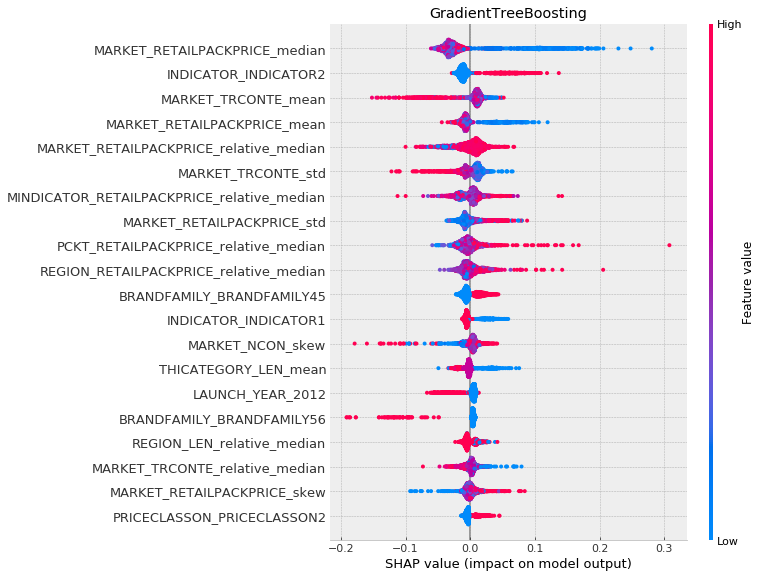

In [115]:
shap.summary_plot(shap_values_1, X, show=False)
plt.title('GradientTreeBoosting')

plt.savefig(os.path.join(plots_dir, 'GradientTreeBoosting_f_imp'), bbox_inches='tight')
plt.show()

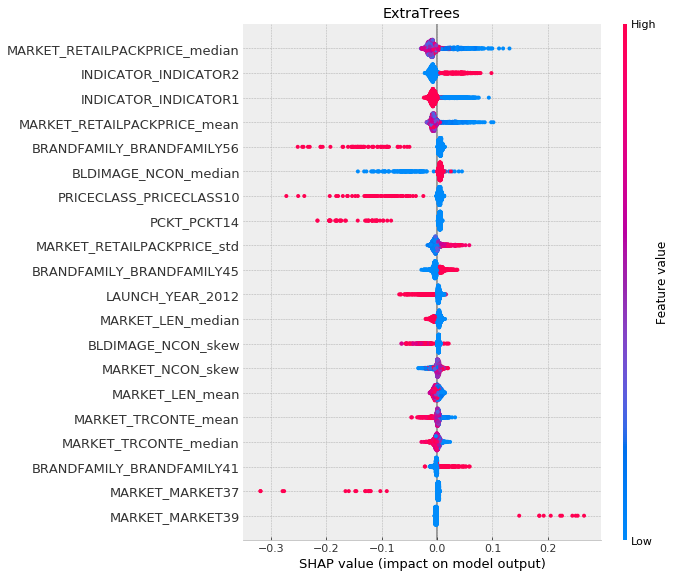

In [116]:
shap.summary_plot(shap_values_2, X, show=False)
plt.title('ExtraTrees')

plt.savefig(os.path.join(plots_dir, 'ExtraTrees_f_imp'), bbox_inches='tight')
plt.show()

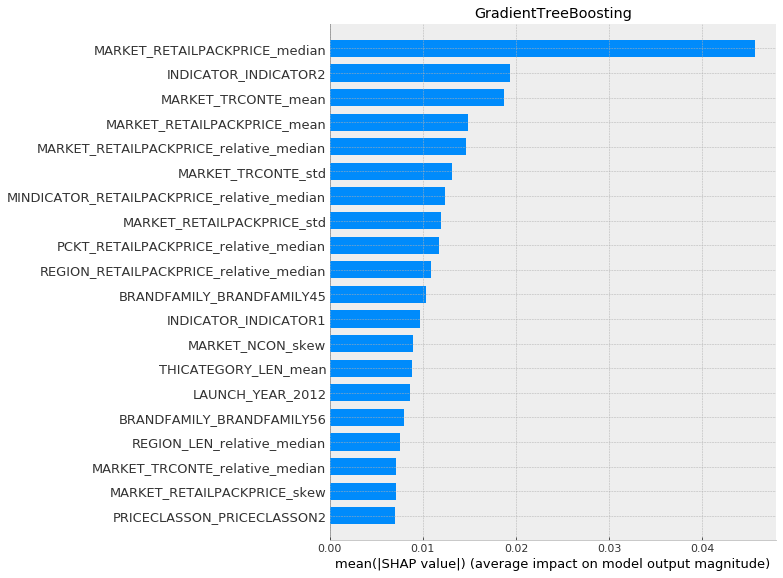

In [57]:
shap.summary_plot(shap_values_1, X, show=False, plot_type='bar')
plt.title('GradientTreeBoosting')

plt.savefig(os.path.join(plots_dir, 'GradientTreeBoosting_f_imp_bar'), bbox_inches='tight')
plt.show()

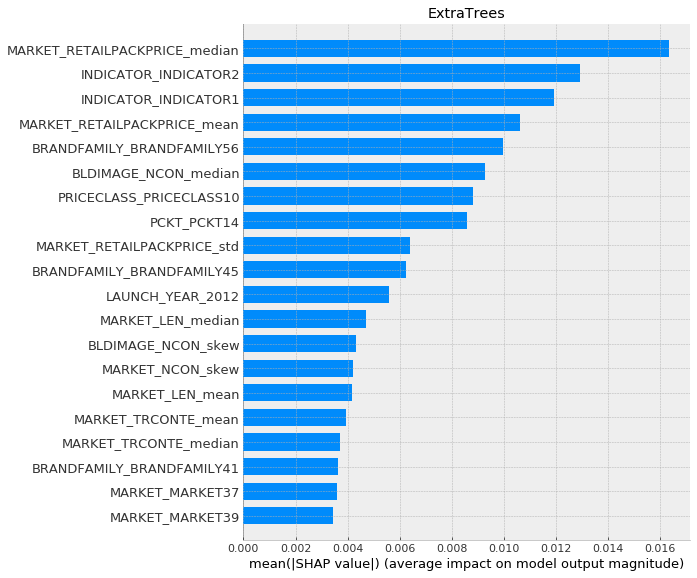

In [117]:
shap.summary_plot(shap_values_2, X, show=False, plot_type='bar')
plt.title('ExtraTrees')

plt.savefig(os.path.join(plots_dir, 'ExtraTrees_f_imp_bar'), bbox_inches='tight')
plt.show()


**SHAP Dependence Plot**

While a SHAP summary plot gives a general overview of each feature a SHAP dependence plot show how the model output varies by feauture value. Note that every dot is a person, and the vertical dispersion at a single feature value results from interaction effects in the model. The feature used for coloring is automatically chosen to highlight what might be driving these interactions. Later we will see how to check that the interaction is really in the model with SHAP interaction values. Note that the row of a SHAP summary plot results from projecting the points of a SHAP dependence plot onto the y-axis, then recoloring by the feature itself.

Below we give the SHAP dependence plot for each of the NHANES I features, revealing interesting but expected trends. Keep in mind the calibration of some of these values can be different than a modern lab test so be careful drawing conclusions.

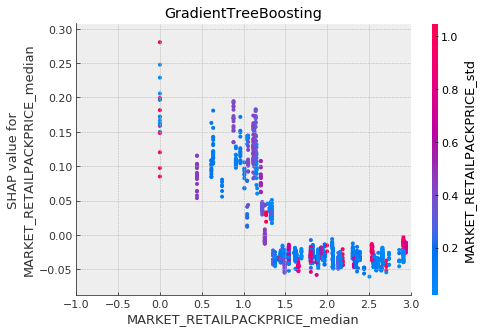

In [89]:
shap.dependence_plot("MARKET_RETAILPACKPRICE_median", shap_values_1, X, show=False, 
                     interaction_index='MARKET_RETAILPACKPRICE_std')
plt.title('GradientTreeBoosting')
plt.xlim(xmin=-1, xmax=3)

plt.savefig(os.path.join(plots_dir, 'GradientTreeBoosting_dep_MARKET_RETAILPACKPRICE_median'), bbox_inches='tight')
plt.show()

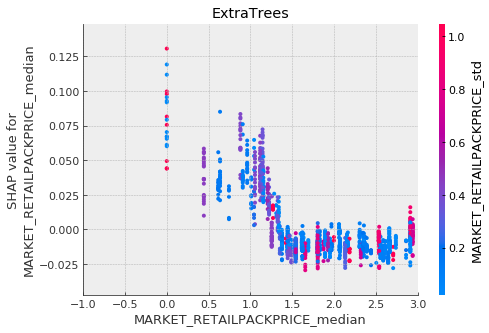

In [118]:
shap.dependence_plot("MARKET_RETAILPACKPRICE_median", shap_values_2, X, show=False, 
                     interaction_index='MARKET_RETAILPACKPRICE_std')
plt.title('ExtraTrees')
plt.xlim(xmin=-1, xmax=3)

plt.savefig(os.path.join(plots_dir, 'ExtraTrees_dep_MARKET_RETAILPACKPRICE_median'), bbox_inches='tight')
plt.show()

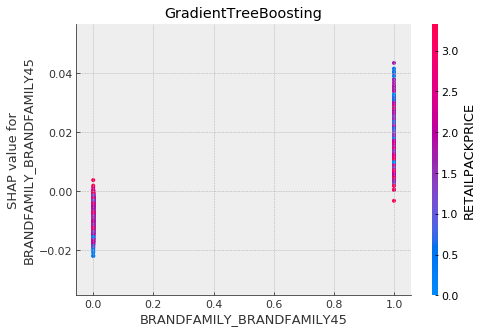

In [124]:
shap.dependence_plot("BRANDFAMILY_BRANDFAMILY45", shap_values_1, X, show=False, 
                     interaction_index='RETAILPACKPRICE')
plt.title('GradientTreeBoosting')
# plt.xlim(xmin=-1, xmax=3)

plt.savefig(os.path.join(plots_dir, 'GradientTreeBoosting_dep_BRANDFAMILY_BRANDFAMILY45'), bbox_inches='tight')
plt.show()

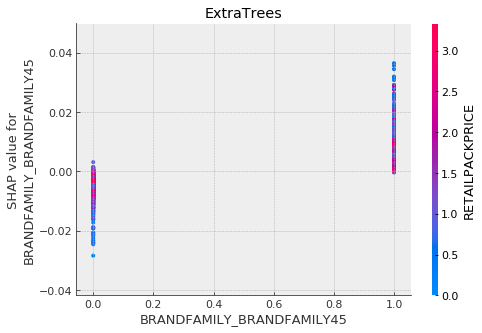

In [125]:
shap.dependence_plot("BRANDFAMILY_BRANDFAMILY45", shap_values_2, X, show=False, 
                     interaction_index='RETAILPACKPRICE')
plt.title('ExtraTrees')

plt.savefig(os.path.join(plots_dir, 'ExtraTrees_dep_BRANDFAMILY_BRANDFAMILY45'), bbox_inches='tight')
plt.show()

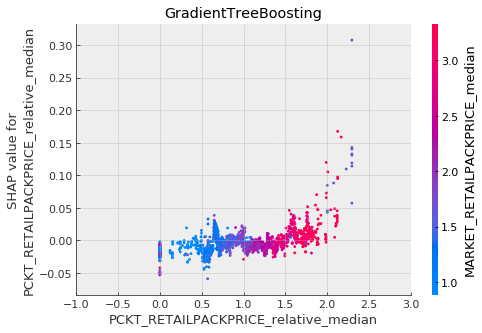

In [274]:
shap.dependence_plot("PCKT_RETAILPACKPRICE_relative_median", shap_values_1, X, show=False, dot_size=8,
                     interaction_index='MARKET_RETAILPACKPRICE_median',)
plt.title('GradientTreeBoosting')
plt.xlim(xmin=-1, xmax=3)

plt.savefig(os.path.join(plots_dir, 'GradientTreeBoosting_PCKT_RETAILPACKPRICE_relative_median'), bbox_inches='tight')
plt.show()

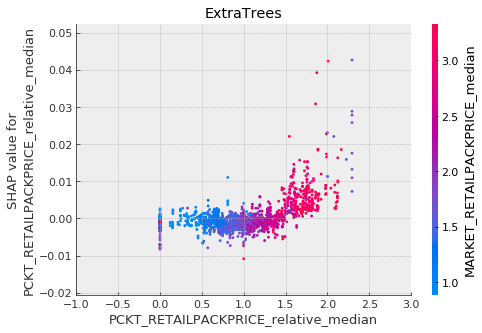

In [155]:
shap.dependence_plot("PCKT_RETAILPACKPRICE_relative_median", shap_values_2, X, show=False, dot_size=8,
                     interaction_index='MARKET_RETAILPACKPRICE_median',)
plt.title('ExtraTrees')
plt.xlim(xmin=-1, xmax=3)

plt.savefig(os.path.join(plots_dir, 'ExtraTrees_PCKT_RETAILPACKPRICE_relative_median'), bbox_inches='tight')
plt.show()

From graphs we can see that different features are important for dfferent models. If we take into consideration only GradiendBoosting and ExtraTrees then we can see for both models there is a common tendency that **RETAILPACKPRICE** related features are important. This is is quite intuitive: in reality market share depends on price.

### Final Prediction

**Prediticting and saving**

In [158]:
# Before final prediction we will use all our data for training
average_model = AveragingModels([
    ExtraTreesRegressor(**final_extratree_params),
    lgb.LGBMRegressor(**final_lgb_params)
])
average_model.fit(training_df.drop(columns='Market_Share'), training_df['Market_Share'])

AveragingModels(models=[ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=60,
          max_features=0.8, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0002, n_estimators=400, n_jobs=2,
  ...0.0, reg_lambda=0.0, silent=True,
       subsample=0.8, subsample_for_bin=200000, subsample_freq=1)])

In [159]:
# Predicting
prediction = average_model.predict(score_df)

# inverse transform
prediction = inv_boxcox(prediction, 0.25)

In [160]:
initial_score_df = pd.read_csv('score_data.csv')
initial_score_df['Market_Share'] = prediction
initial_score_df['Success']  = initial_score_df['Market_Share'] > 0.007
initial_score_df.to_csv('score_data_predicted.csv')

**Visualization**

In [255]:
initial_score_df_cols = ['MARKET', 'BRANDFAMILY', 'INDICATOR', 'PCKT', 'RETAILPACKPRICE', 'Market_Share', 'Success']
score_df_cols = ['MARKET_RETAILPACKPRICE_median', 'MARKET_TRCONTE_mean',]

temp_1 = score_df[score_df_cols]
temp_1.reset_index(inplace=True, drop=True)
temp_2 = initial_score_df[initial_score_df_cols]

df_viz = temp_1.join(temp_2)
for col, _dtype in zip(df_viz.columns, df_viz.dtypes):
    if _dtype == 'object':
        df_viz[col] = df_viz[col].apply(lambda x: str(x).replace(col, ''))

In [256]:
df_viz = df_viz[['MARKET', 'BRANDFAMILY', 'PCKT', 'INDICATOR', 'MARKET_TRCONTE_mean', 'MARKET_RETAILPACKPRICE_median', 'RETAILPACKPRICE', 'Market_Share', 'Success']]
df_viz['Market_Share'] *= 100
df_viz.rename(columns={'Market_Share': 'Market_Share %'}, inplace=True)
df_viz[df_viz['Success'] == True]

,MARKET,BRANDFAMILY,PCKT,INDICATOR,MARKET_TRCONTE_mean,MARKET_RETAILPACKPRICE_median,RETAILPACKPRICE,Market_Share %,Success
2,7,12,11,1,9.000000,2.068674,27.00,2.239268,True
3,7,12,11,1,9.000000,2.068674,29.25,1.783011,True
12,86,39,28,1,2.166667,0.960657,30.00,1.492273,True
13,48,45,11,1,2.166667,0.960657,31.00,0.782650,True
17,89,45,12,1,1.066667,2.343504,15.00,0.953220,True
24,49,17,28,1,1.066667,2.343504,4.40,1.332931,True
25,49,17,11,1,5.192308,1.803598,4.10,1.056563,True
26,30,45,11,1,5.192308,1.803598,2.25,1.116020,True


In [260]:
shap.initjs()

In [325]:
# SHAP values for 2 models
score_shape_values_1 = explainer_1.shap_values(score_df)
score_shape_values_2 = explainer_2.shap_values(score_df)

In [311]:
shap.force_plot(explainer_1.expected_value, score_shape_values_1[0], score_df.iloc[0])

In [324]:
shap.force_plot(explainer_1.expected_value, score_shape_values_1[12], score_df.iloc[12])

In [334]:
shap.force_plot(explainer_2.expected_value, score_shape_values_2[26], score_df.iloc[26])

In [273]:
shap.force_plot(explainer_1.expected_value, score_shape_values_1, score_df)